
# Getting started

Once you've chosen your scenario, download the data from the Iowa website in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [2]:
raw_data = 'C:/Users/William/Downloads/iowa.csv'
extra_data_target = 'C:/Users/William/Documents/GA/Data/LiquorExtra.csv'
clean_data_target = 'C:/Users/William/Documents/GA/Data/LiquorWork.csv'

# Zip data taken from <https://www.gaslampmedia.com/download-zip-code-latitude-longitude-city-state-county-csv/>
zips_data_raw = 'C:/Users/William/Downloads/zip_codes_states.csv'
zips_ia_target = 'C:/Users/William/Documents/GA/Data/IAZipCodes.csv'

#Population Data
pop_data_raw = 'C:/Users/William/Downloads/Crosstab_data.csv'
pop_fixed_target = 'C:/Users/William/Documents/GA/Data/IAPopulation'
#http://www.iowadatacenter.org/data/estimates/2015/city-county-2015

## Take a look at Raw Data for inconsistencies

In [71]:
lf = pd.read_csv(raw_data)

C:\Users\William\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [73]:
def findDuplicates(keyCol, valCol, data):
    to = time.time()
    numName = {}
    for row in data[[keyCol, valCol]].iterrows():
        if row[1][0] in numName:
            if row[1][1] in numName[row[1][0]]:
                pass
            else:
                numName[row[1][0]].append(row[1][1])
        else:
            numName[row[1][0]] = [row[1][1]]
    numName = {k:numName[k] for k in numName if len(numName[k])!=1}
    t1 = time.time()
    print(t1-to)
    return numName

def normalizeNames(itemDict, col1, col2, data):
    for k in itemDict:
        data.loc[data[col1]==k, col2] = itemDict[k][0]

206.26632952690125
204.74371433258057
210.76867389678955


In [ ]:
itemPerVendorDup = findDuplicates('Item Number', 'Vendor Name', lf)
itemPerDescriptionDup = findDuplicates('Item Number', 'Item Description', lf)
numPerVendorDup = findDuplicates('Vendor Number', 'Vendor Name', lf)

In [ ]:
print(itemPerVendorDup)
print()
print(itemPerDescriptionDup)
print()
print(numPerVendorDup)

Using Google, it appears that the item/vendor changes are due to mergers/aquisitions etc.  

The item/description differences and vendor number/name difference appear to simply be different spellings. Those seem like good candidates for normalizing. 

The item/vendor differences, on the other hand, do contain some information.

In [134]:
del(lf)

## Clean Up Raw Liquor Data

In [70]:
# All-in-one Cell
#Reading in data and creating smaller versions
import time
t0 = time.time()

#Imports
import pandas as pd

# Target paths for re-saving dat
raw_data = 'C:/Users/William/Downloads/iowa.csv'
extra_data_target = 'C:/Users/William/Documents/GA/Data/LiquorExtra.csv'
clean_data_target = 'C:/Users/William/Documents/GA/Data/LiquorWork.csv'

# Zip data taken from <https://www.gaslampmedia.com/download-zip-code-latitude-longitude-city-state-county-csv/>
zips_data_raw = 'C:/Users/William/Downloads/zip_codes_states.csv'
zips_ia_target = 'C:/Users/William/Documents/GA/Data/IAZipCodes.csv'

# Read in Full data
liquor = pd.read_csv(raw_data)

####
# Define function to search for inconsistencies in name v/ number
# Used here to normalize names
####

def findDuplicates(keyCol, valCol, data):
    tInit = time.time()
    
    numName = {}
    
    # .iterrows() returns a tuple where the [1]st element is the data, and the [0] the element of that refers to the 
    #     data in the first column and the [1]st element of the second column
    for row in data[[keyCol, valCol]].iterrows():
        if row[1][0] in numName:
            if row[1][1] in numName[row[1][0]]:
                pass
            else:
                numName[row[1][0]].append(row[1][1])
        else:
            numName[row[1][0]] = [row[1][1]]
    
    # Search for keys with more than one value
    numName = {k:numName[k] for k in numName if len(numName[k])!=1}
    
    tEnd = time.time()
    print(tEnd-tInit)
    return numName

###
# Function for converting Names Found to be Duplicates
####

def normalizeNames(itemDict, col1, col2, data):
    for k in itemDict:
        data.loc[data[col1]==k, col2] = itemDict[k][0]
        
#itemPerVendorDup = findDuplicates('Item Number', 'Vendor Name', liquor)
itemPerDescriptionDup = findDuplicates('Item Number', 'Item Description', liquor)
numPerVendorDup = findDuplicates('Vendor Number', 'Vendor Name', liquor)

normalizeNames(itemPerDescriptionDup, 'Item Number', 'Item Description', liquor)
normalizeNames(numPerVendorDup, 'Vendor Number', 'Vendor Name', liquor)
        
####
# Getting rid of unneeded features
#     Particular addresses, Store Names and Store Location [which is full address]
#     Are not relevant here.
#     Category/Name are sparse.
#     Volume sold(s), and total dollars are information already contained in the data
#     vis number sold and retail price
####

unneeded = liquor.filter(['Address','Store Name', 'Category','Store Location',
                          'County Number','Category Name','Volume Sold (Liters)',
                          'Vendor Name', 'Volume Sold (Gallons)', 'Sale (Dollars)'])

unneeded.to_csv(extra_data_target)
del(unneeded)

liquor = liquor.drop(['Address','Store Name', 'Category', 'Store Location',
                      'County Number', 'Category Name', 'Volume Sold (Liters)',
                      'Vendor Name','Volume Sold (Gallons)', 'Sale (Dollars)'], axis = 1)

####
# Using Zip data to help impute missing values in county and zip code data.
#      Only interested in information from Iowa, thus cutting down zip data
####
zips = pd.read_csv(zips_data_raw)
zips = zips[zips['state']=='IA']

zips.to_csv(zips_ia_target)

#####
# Imputing missing County data via zip codes from external file
#
#      Zip codes in the liquor data is complete, but it contains '712-2' which cannot be converted to an int
#      Given other data, impute using zip data
#####

# For all indexes where either 'county' is null or the zip code is 712-2
for index in liquor[(pd.isnull(liquor['County'])) | (liquor['Zip Code']=='712-2')].index:
    # Try to give the county number found adjacent to the zip-code in external data
    try: 
        liquor.loc[index,'County'] = zips[zips['zip_code'] == int(liquor.loc[index,'Zip Code'])].county.iloc[0]
    
    # Upon failure, instead of referencing the zip code, reference the city to impute both zip and county
    except:
        liquor.loc[index,'Zip Code'] = zips[zips['city'] == liquor.loc[index,'City'].lower().capitalize()]['zip_code'].iloc[0]
        liquor.loc[index,'County'] = zips[zips['city'] == liquor.loc[index,'City'].lower().capitalize()]['county'].iloc[0]

        
# Conversion of strings to numbers        
liquor['Zip Code'] = liquor['Zip Code'].astype(int)
liquor['State Bottle Cost'] = liquor['State Bottle Cost'].str.replace('$','').astype(float)
liquor['State Bottle Retail'] = liquor['State Bottle Retail'].str.replace('$','').astype(float)


# Rename columns for brevity
liquor.columns =['Invoice', 'Date', 'StNum', 'City',
                'Zip', 'County', 'VenNum','ItNum', 'Item',
                 'Pack', 'BottVol', 'Cost', 'Retail', 'Num Sold']

# Round cost and retail to cents
liquor.Retail = liquor.Retail.round(2)
liquor.Cost = liquor.Cost.round(2)

####
# Create Month and Year vars from date
####
liquor['Date'] = pd.to_datetime(liquor["Date"], format="%m/%d/%Y")
liquor['Month'] = [d.month for d in liquor['Date']]
liquor['Year'] = [d.year for d in liquor['Date']]
liquor['MonthOrder'] = [d.month if d.year == 2015 else d.month+12 for d in liquor['Date']]


####
# Define then apply function for spelling mistakes / Standardization found in city names.
# All found via comparison to Iowa 'Population' data set found below
####

def spellingCheck(val):
    dic = {
    'DEWITT':'DE WITT',
    'LEMARS':'LE MARS',
    'MT PLEASANT':'MOUNT PLEASANT',
    'OTTUWMA':'OTTUMWA',
    'KELLOG':'KELLOGG',
    'ARNOLD\'S PARK':'ARNOLDS PARK',
    'JEWELL': 'JEWELL JUNCTION',
    'LECLAIRE': 'LE CLAIRE',
    'MT VERNON': 'MOUNT VERNON',
    'GUTTENBURG': 'GUTTENBERG'
    }
    
    if val in dic:
        return dic[val]
    else:
        return val
    
liquor['City'] = liquor['City'].apply(spellingCheck)

####
# Some of the cities are misclassified in thier counties, this dictionary gives the city name
# Then the desired county
####

countyDic={
        'CORNING':'Adams',
        'NORTH LIBERTY':'Johnson',
        'PERRY':'Dallas',
        'STATE CENTER':'Marshall',
        'FORT DODGE':'Webster',
        'OSKALOOSA':'Mahaska',
        'BETTENDORF':'Scott',
        'GLADBROOK':'Tama',
        'WELLMAN': 'Washington',
        'CAMBRIDGE': 'Story',
        'NEWTON':'Jasper',
        'ACKLEY':'Hardin'} 

####
# Needing to cross reference city and county means that an "apply" function does not work
####

# Create a df, of all the unique counties attributed to each city
#     (Note some cities do lie in multiple counties)

cc = liquor[['City','County']].groupby('City')['County'].unique()

#Dictionaries to populate in loop
# cdicW is a dictionary of the town names as keys and incorrect counties as value
cdic = {}
cdicW= {}

# For all multi-county cities, if it is in the dictionary above, populate the dictionaries for necessary changes 
for i in cc.index:
    if len(cc.loc[i]) >1:
        if i in countyDic:
            if cc.loc[i][0] != countyDic[i]:
                cou = cc.loc[i][0]
            else:
                cou = cc.loc[i][1]
            
            cdic[i] = countyDic[i]
            cdicW[i] = cou
            
# Final error found in Munging
cdic['CAMBRIDGE'] = 'Story'
cdicW['CAMBRIDGE'] = 'Polk'

# for every element in dictionary that needs changes
# Go through entries that contain that key AND have the wrong county
# Then change to the correct county
for k in cdic:
    #print(k)
    for i in liquor[(liquor['City']==k) & (liquor['County']==cdicW[k])].index:
        liquor.loc[i,'County'] = cdic[k]
        
# Write to file
liquor.to_csv(clean_data_target)

del(zips)
del(liquor)
t1 = time.time()

print(t1-t0)

C:\Users\William\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


193.45141506195068
195.81952452659607
1863.4780366420746


## Read in Cleaned Liquor Data

In [174]:
import time
t0 = time.time()
import pandas as pd
clean_data_target = 'C:/Users/William/Documents/GA/Data/LiquorWork.csv'

liquor = pd.read_csv(clean_data_target ,index_col=0)

t1 = time.time()
print(t1-t0)

C:\Users\William\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


6.977480411529541


### Create Table describing each store's imutable characteristics  
e.g. town, county, zip, county and city population

To be used as something of a 'code book' when aggregating the liquor data.

In [142]:
import pandas as pd

# Population Data
# From <http://www.iowadatacenter.org/data/estimates/2015/city-county-2015>
pop_data_raw = 'C:/Users/William/Downloads/Crosstab_data.csv'
pop_fixed_target = 'C:/Users/William/Documents/GA/Data/IAPopulation'

# .csv comes in as list of tuples
popRaw = pd.read_csv(pop_data_raw)

pop = pd.DataFrame(columns = ['County','Town','Population'])
for i, town in enumerate(popRaw.index):
    pop.loc[i] = [town[0],town[1],town[2]]

# Find county populations and add new variable for all towns
gb = pop.groupby('County').Population.sum()
pop['CountyPop'] = [gb.loc[cn] for cn in pop['County']]

# String Cleaning to allow for easier merging with other data
pop['Town'] = pop['Town'].str.replace(' \(pt.\)','')
pop['County'] = pop['County'].str.replace(' County', '')
pop['Town'] = pop['Town'].str.replace('.','')
pop['Town'] = pop['Town'].str.replace('\'', '')

# Missing from downloaded data, present in liquor data, imputed
pop.loc[len(pop)] = ['Black Hawk','Washburn', 879, 133499] # From wikipedia

stList = pd.DataFrame()
stList['County'] = liquor[['StNum','City','Zip','County']].groupby('StNum')['County'].unique()
stList['Zip'] = liquor[['StNum','City','Zip','County']].groupby('StNum')['Zip'].unique()
stList['City'] = liquor[['StNum','City','Zip','County']].groupby('StNum')['City'].unique()

####
# Deprecated

# multi = []
# for i in stList.index:
#     if(len(stList.loc[i]['County']) ==1) & (len(stList.loc[i]['Zip'] ==1))&(len(stList.loc[i]['Zip'] ==1)):
#         pass
#     else:
#         multi.append(i)
# print(multi)

####

# 'unique()' returns list. Above loop ensured each only had one element
for col in stList:
    stList[col] = [e[0] for e in stList[col]]

# For ease of merge with liquor data    
stList['City'] = stList['City'].apply(str.upper)    

####
# Function to populate lists for town populations and county populations
# corresponding to each store. Maybe unneeded with a two-factor Merge, but...
####

def addPops(storeList, townP, countyP):
    for row in storeList.index:

        lTown = storeList.loc[row]['City'].title()
        lCounty = storeList.loc[row]['County']

        if lTown in pop['Town'].unique():
            popRow = pop[pop['Town'] == lTown]
            
            while len(popRow) != 1:
                if lCounty in pop['County'].unique():
                    popRow = popRow[popRow['County'] == lCounty]
                break

            if len(popRow) ==1:
                # if popRow['County'].iloc[0] != lCounty:
                    # print(lTown, lCounty)
                townP.append(popRow['Population'].iloc[0])
                countyP.append(popRow['CountyPop'].iloc[0])

            else:
                townP.append(None)
                countyP.append(None)

        else:
            # print(lTown, lCounty, 'NO')
            townP.append(None)
            countyP.append(None)
    return(townP, countyP)

# Add in those population lists
tup = addPops(stList, [], [])

stList['CityPop'] = tup[0]
stList['CountyPop'] = tup[1]

# Replace index with numbers, and place store numbers in column
stList['StNum'] = stList.index
stList.index = range(0,len(stList))



#List of stores NOT active during entire period
s = liquor.groupby(['StNum'])['MonthOrder'].unique()
incomplete = [i for i in s.index if len(s[i])<15]

# Count liquor stores by County and City to merge onto store list 
countLiqS = pd.DataFrame(stList.groupby('County')['StNum'].unique())
countLiqS['CountyStoresMax'] = countLiqS['StNum'].apply(len)
countLiqS['CountyStoresMin'] = countLiqS['StNum'].apply(lambda x: [d for d in x if d not in incomplete]).apply(len)

countLiqS['County'] = countLiqS.index
countLiqS.index = range(0, len(countLiqS))
countLiqS = countLiqS.drop('StNum', axis =1)


cityLiqS = pd.DataFrame(stList.groupby('City')['StNum'].unique())
cityLiqS['CityStoresMax'] = cityLiqS['StNum'].apply(len)
cityLiqS['CityStoresMin'] = cityLiqS['StNum'].apply(lambda x: [d for d in x if d not in incomplete]).apply(len)

cityLiqS['City'] = cityLiqS.index
cityLiqS.index = range(0, len(cityLiqS))
cityLiqS = cityLiqS.drop('StNum', axis =1)

stList = stList.merge(countLiqS, on = 'County')
stList = stList.merge(cityLiqS, on = 'City')


####
# County and City lists built
####

def buildDTable(data, group, vals):
    df=pd.concat([data.groupby(group)[v].unique() for v in vals], axis = 1)
    for c in df:
        df[c] = [e[0] for e in df[c]]
    df[group] = df.index
    df.index = range(0,len(df))
    return df

countyList = buildDTable(stList, 'County', ['CountyPop', 'CountyStoresMax','CountyStoresMin'])
cityList = buildDTable(stList, 'City', ['CityPop', 'CityStoresMin','CityStoresMax',
                                        'CountyPop', 'CountyStoresMax','CountyStoresMin', 'County'])

cityList_target = 'C:/Users/William/Documents/GA/Data/cityTable.csv'
countyList_target = 'C:/Users/William/Documents/GA/Data/countyTable.csv'
stList_target = 'C:/Users/William/Documents/GA/Data/storeTable.csv'

stList.to_csv(stList_target)
cityList.to_csv(cityList_target)
countyList.to_csv(countyList_target)

del(cityList)
del(countyList)
del(stList)

#### Aggregate Data from Totals Data Frame

In [49]:
liquor = pd.read_csv(clean_data_target ,index_col=0)

C:\Users\William\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [143]:
%%time
import pandas as pd
clean_data_target = 'C:/Users/William/Documents/GA/Data/LiquorWork.csv'

stList_target = 'C:/Users/William/Documents/GA/Data/storeTable.csv'
cityList_target = 'C:/Users/William/Documents/GA/Data/cityTable.csv'
countyList_target = 'C:/Users/William/Documents/GA/Data/countyTable.csv'

stList = pd.read_csv(stList_target, index_col = 0)
cityList = pd.read_csv(cityList_target, index_col = 0)
countyList = pd.read_csv(countyList_target, index_col = 0)

liquor = pd.read_csv(clean_data_target ,index_col=0)

#Multiplying bottle information by number sold to re-create totals

LA = liquor.drop(['Invoice','Zip', 'Date', 'VenNum', 'Item', 'Pack', 'Year', 'ItNum'], axis = 'columns')
LA['Vol'] = LA['BottVol'] * LA['Num Sold']
LA['TCost'] = LA['Num Sold'] * LA['Cost']
LA['TRetail'] = LA['Num Sold'] * LA['Retail']
LA = LA.drop(['BottVol','Cost','Retail'], axis = 'columns')

####
# Function to build lists that aggregate from liquor data upon specified variables
# then merge with the code books created above
####

def buildAggList(data, agg_on, infoList, merge_on):
    
    df = pd.concat([data.groupby(agg_on)['Vol'].sum(), 
                    data.groupby(agg_on)['TCost'].sum(), 
                    data.groupby(agg_on)['TRetail'].sum(), 
                    data.groupby(agg_on)['Num Sold'].sum()],
                   axis = 1)

    # Getting rid of multi-index, and re-index
    if len(agg_on)> 1:
        for i, val in enumerate(agg_on):
            df[val] = df.index.map(lambda x: x[i])
    elif len(agg_on) == 1:
        df[agg_on[0]] = df.index
        
    df.index = range(0,len(df))

    # Arrange Columns
    cols = df.columns.tolist()
    cols = cols[-len(agg_on):]+cols[:-len(agg_on)]
    df = df[cols]

    # Merge with the "info List"
    if type(infoList) != type(None):
        df = df.merge(infoList, on = merge_on)
    
    return df

stateM = buildAggList(LA, ['MonthOrder'], None, 'StNum' )
storeM = buildAggList(LA, ['StNum','MonthOrder'], stList, 'StNum')
countyM = buildAggList(LA, ['County','MonthOrder'], countyList, 'County')
cityM = buildAggList(LA, ['City','MonthOrder'], cityList, 'City')

storeY = buildAggList(LA, ['StNum'], stList, 'StNum')
countyY = buildAggList(LA, ['County'], countyList, 'County')
cityY = buildAggList(LA, ['City'], cityList, 'City')

s = liquor.groupby(['StNum'])['MonthOrder'].unique()
incomplete = [i for i in s.index if len(s[i])<15]

# Build Year data with stores having 15 months of observations
storeYF = storeY[~storeY['StNum'].isin(incomplete)]

del(liquor)
del(LA)

C:\Users\William\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Wall time: 15.3 s


In [130]:
liquor = pd.read_csv(clean_data_target ,index_col=0)

C:\Users\William\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

%matplotlib inline

### DFs needed for analysis

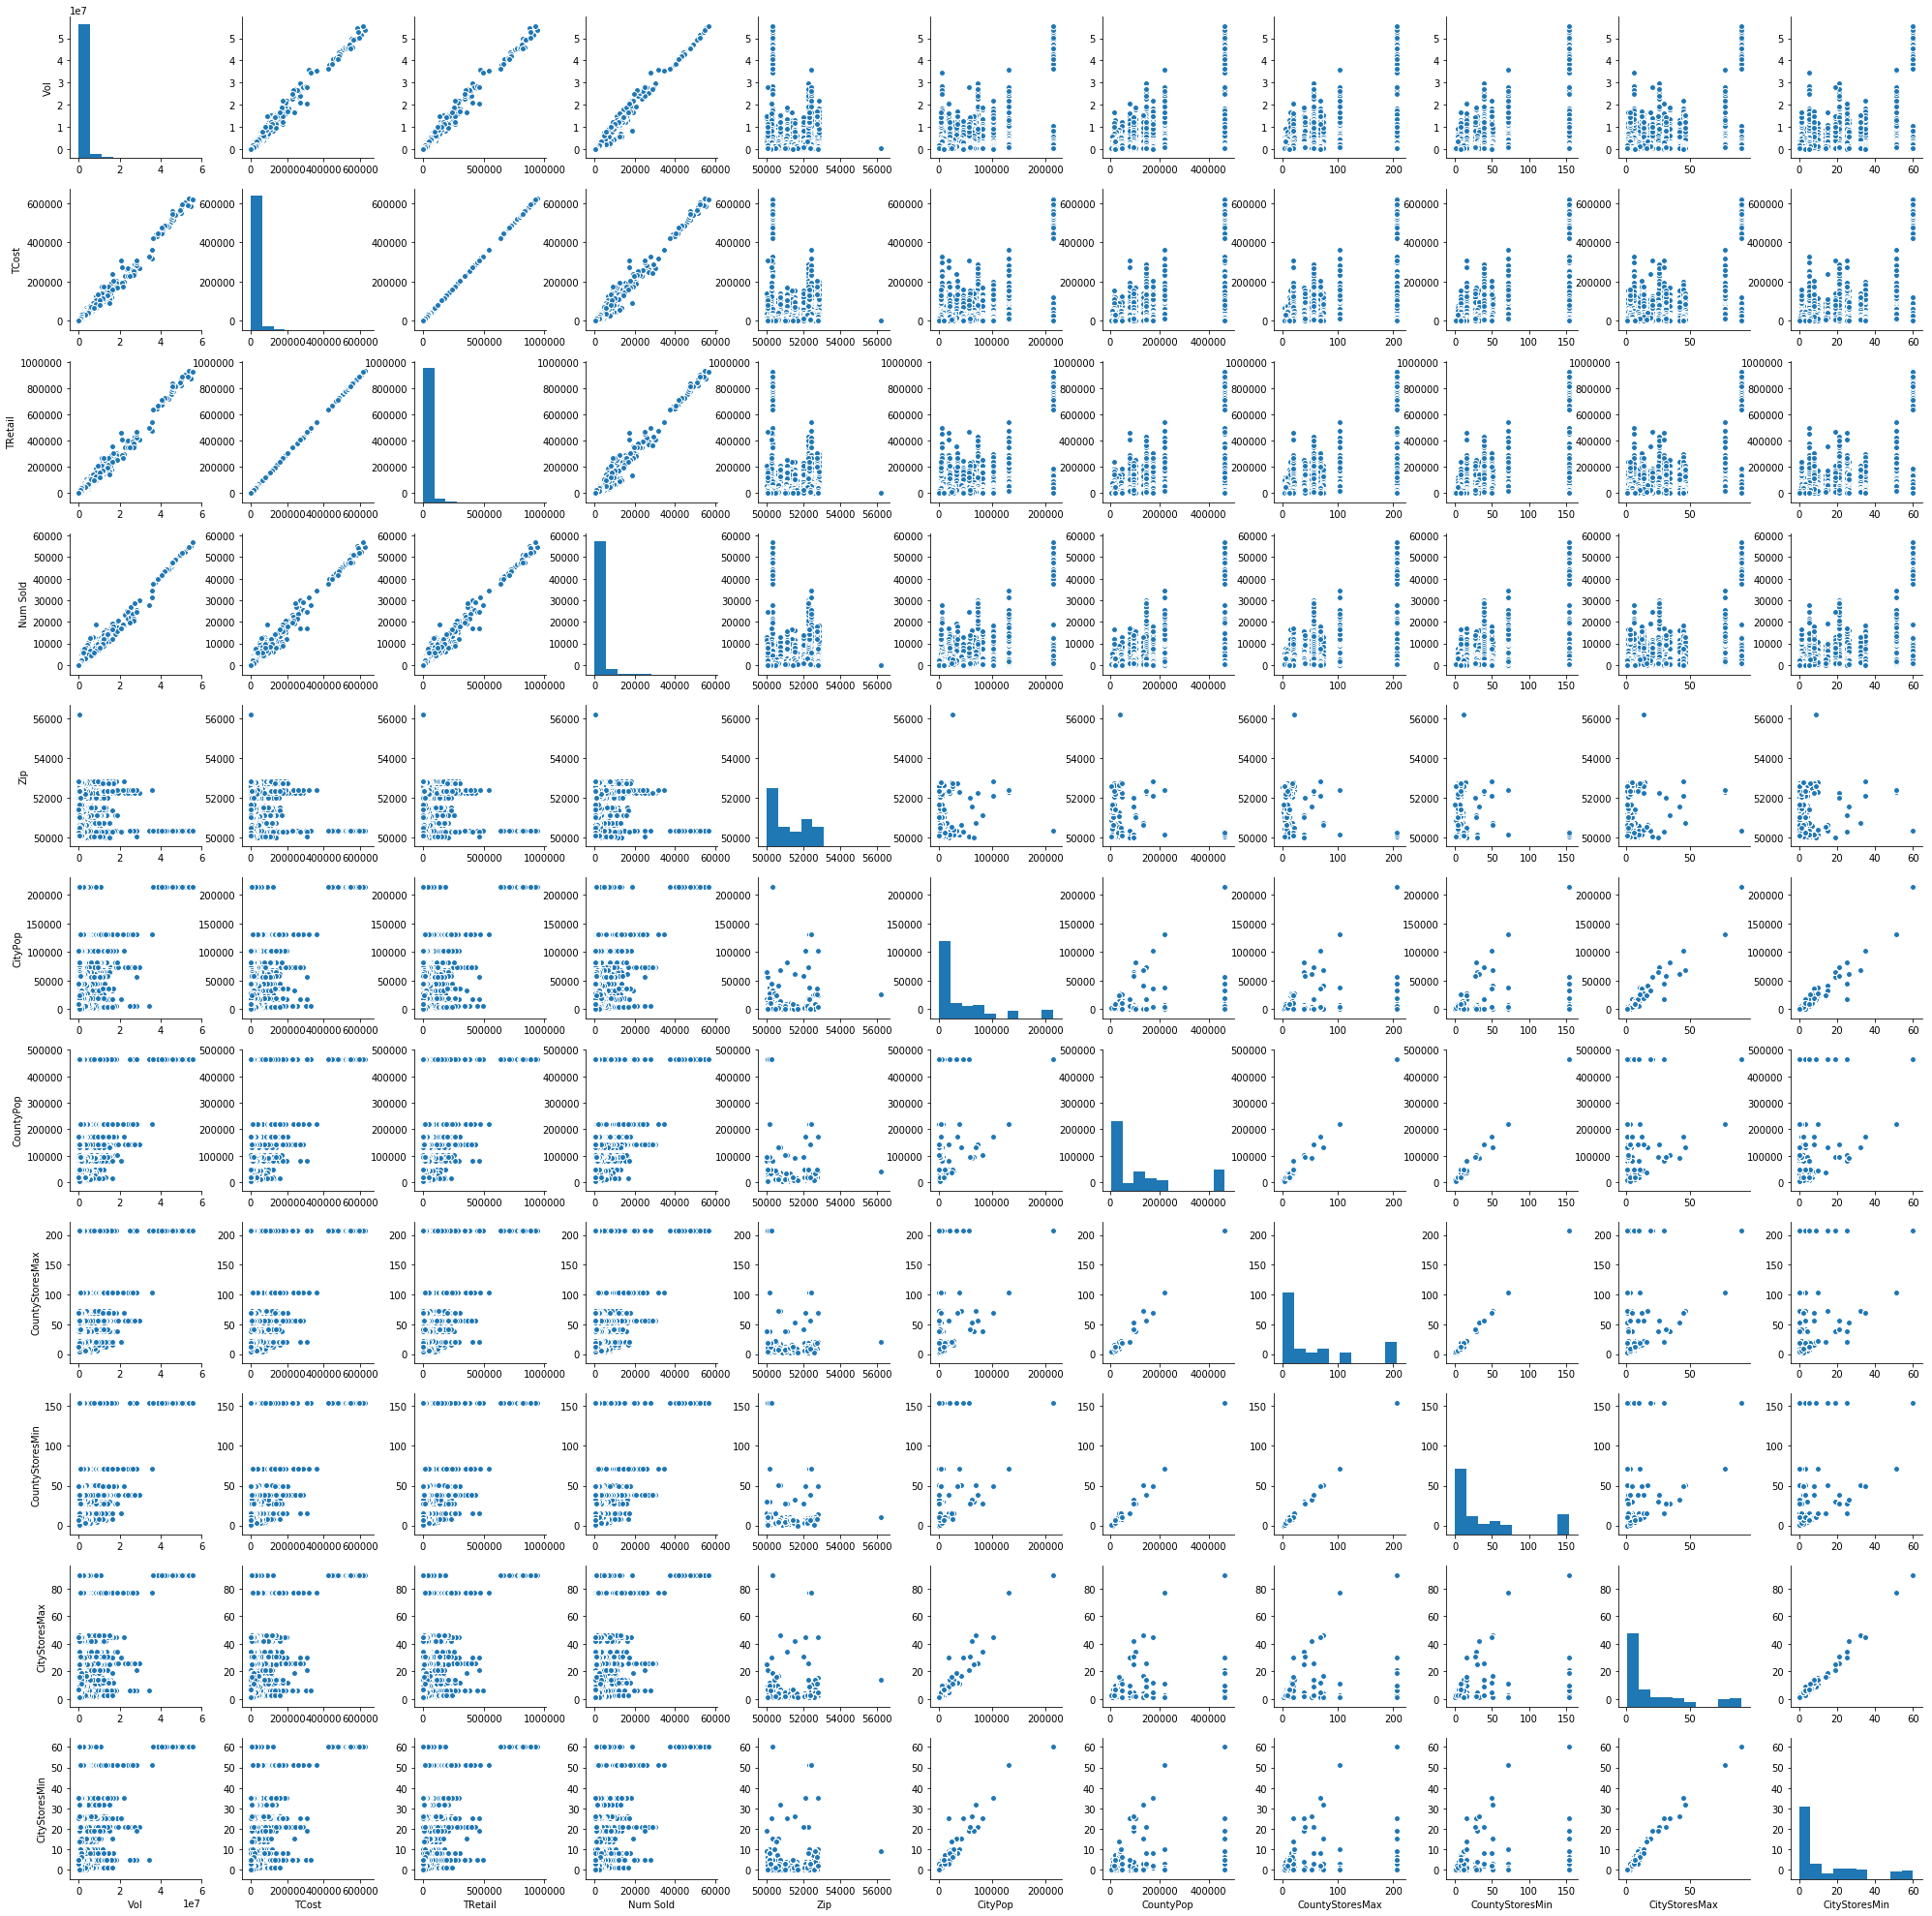

In [213]:
sns.pairplot(storeM.iloc[:,2:]);

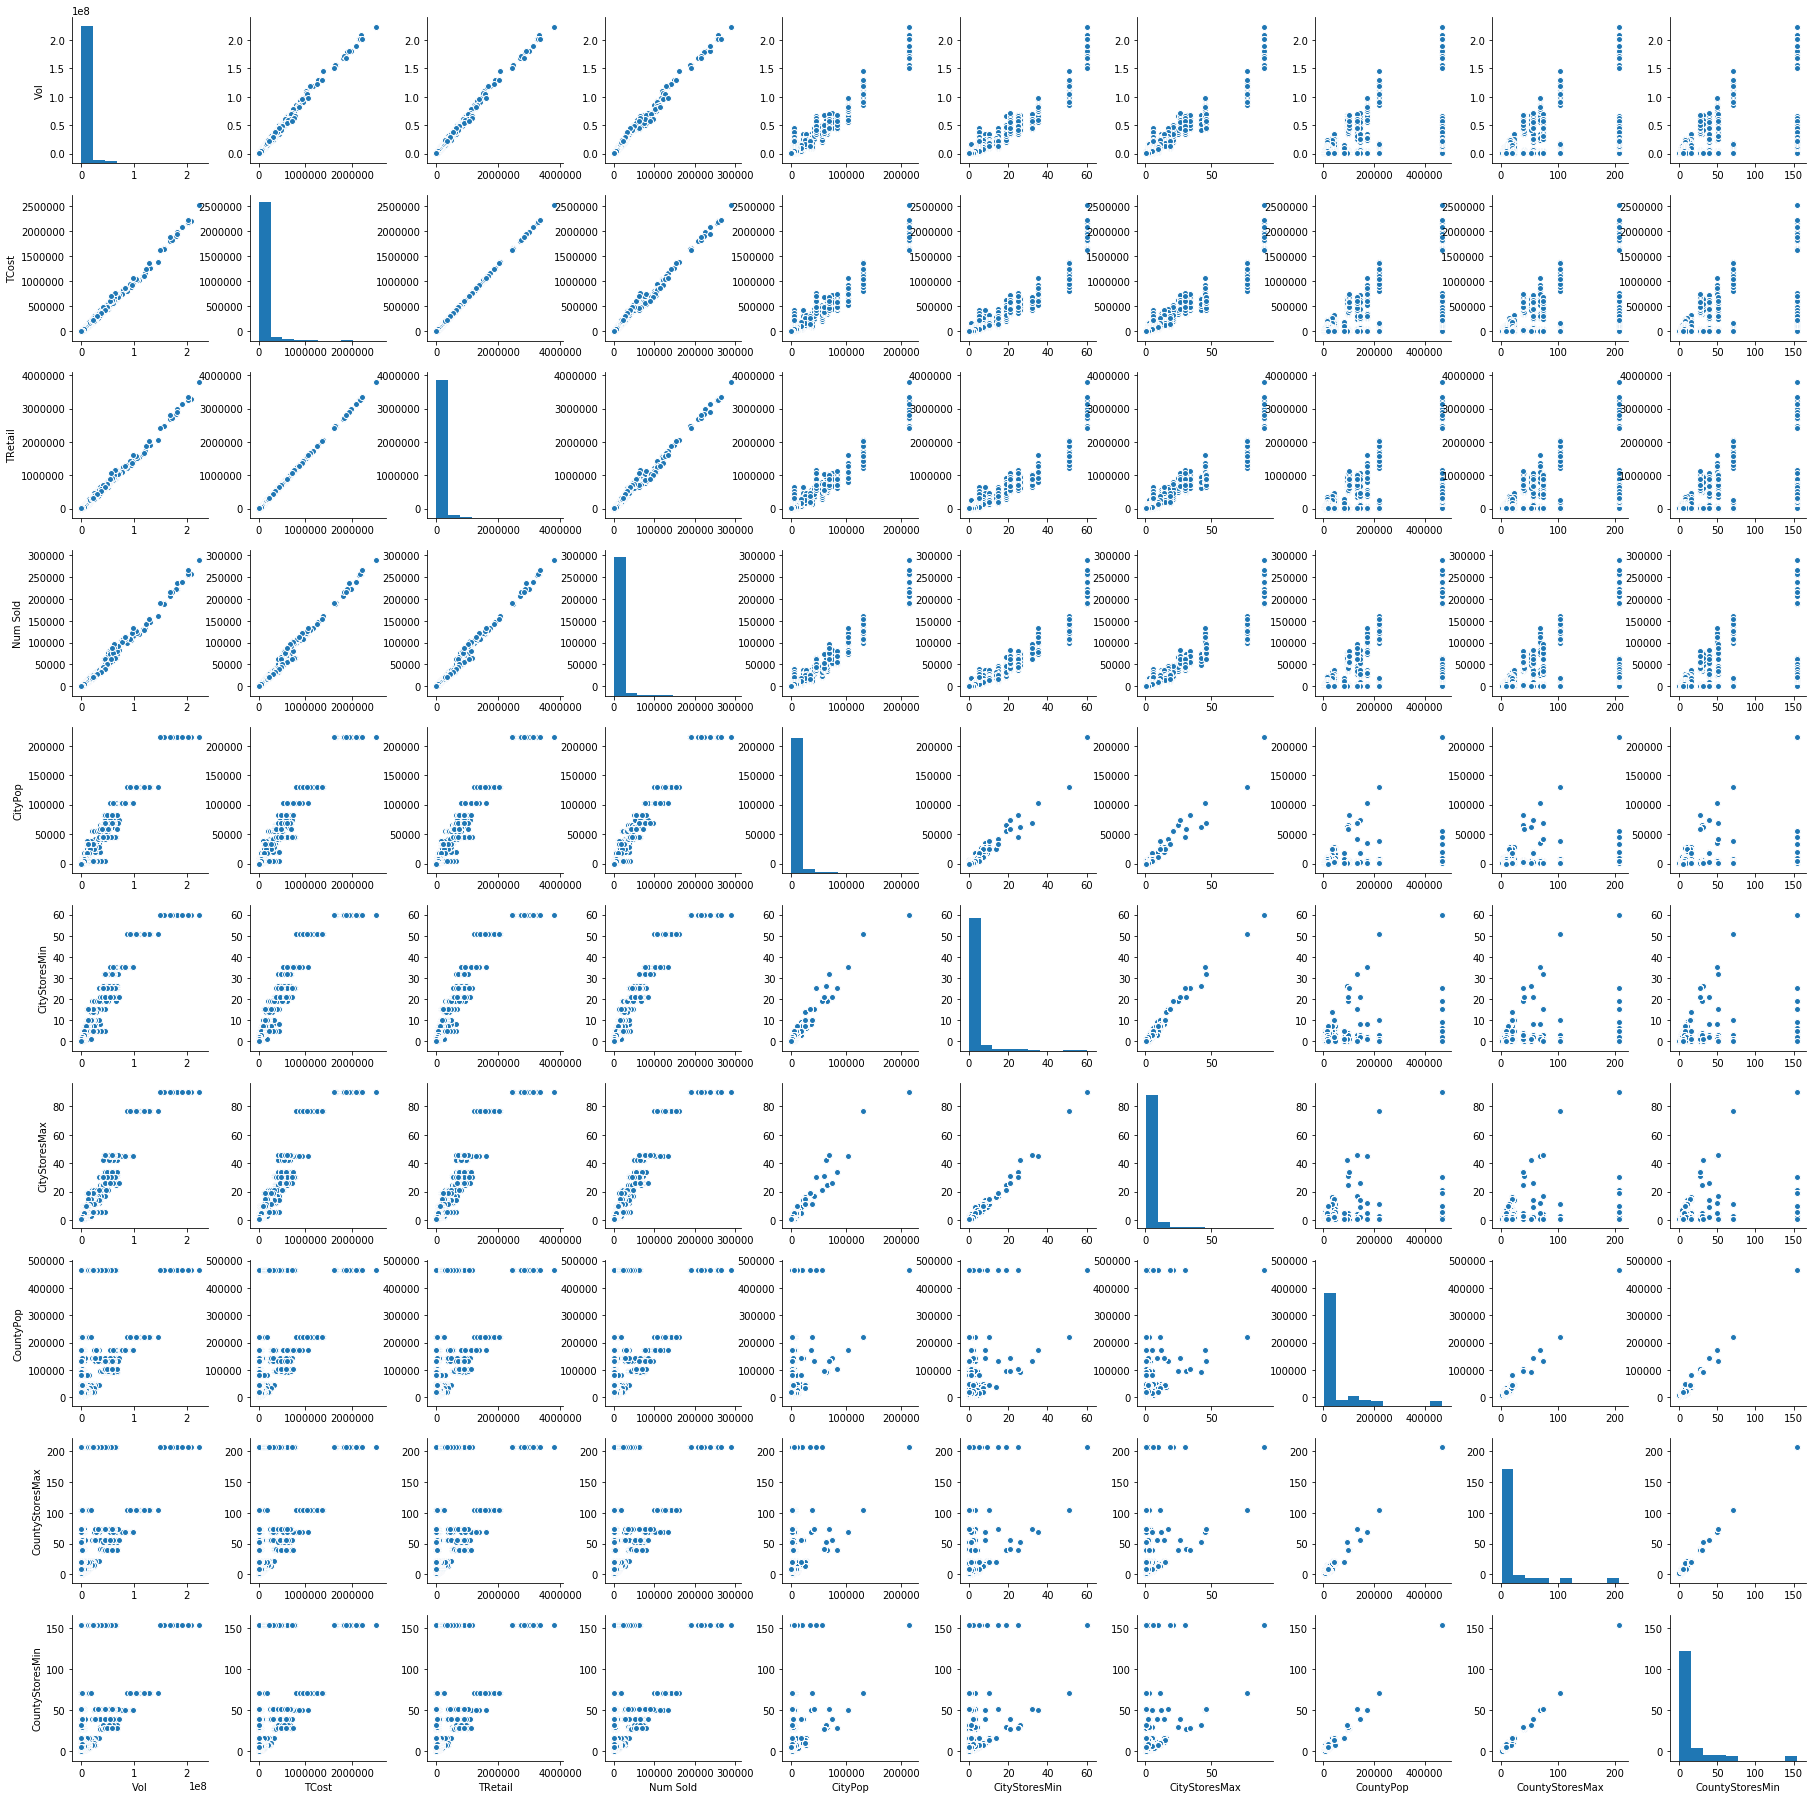

In [214]:
sns.pairplot(cityM.iloc[:,2:]);

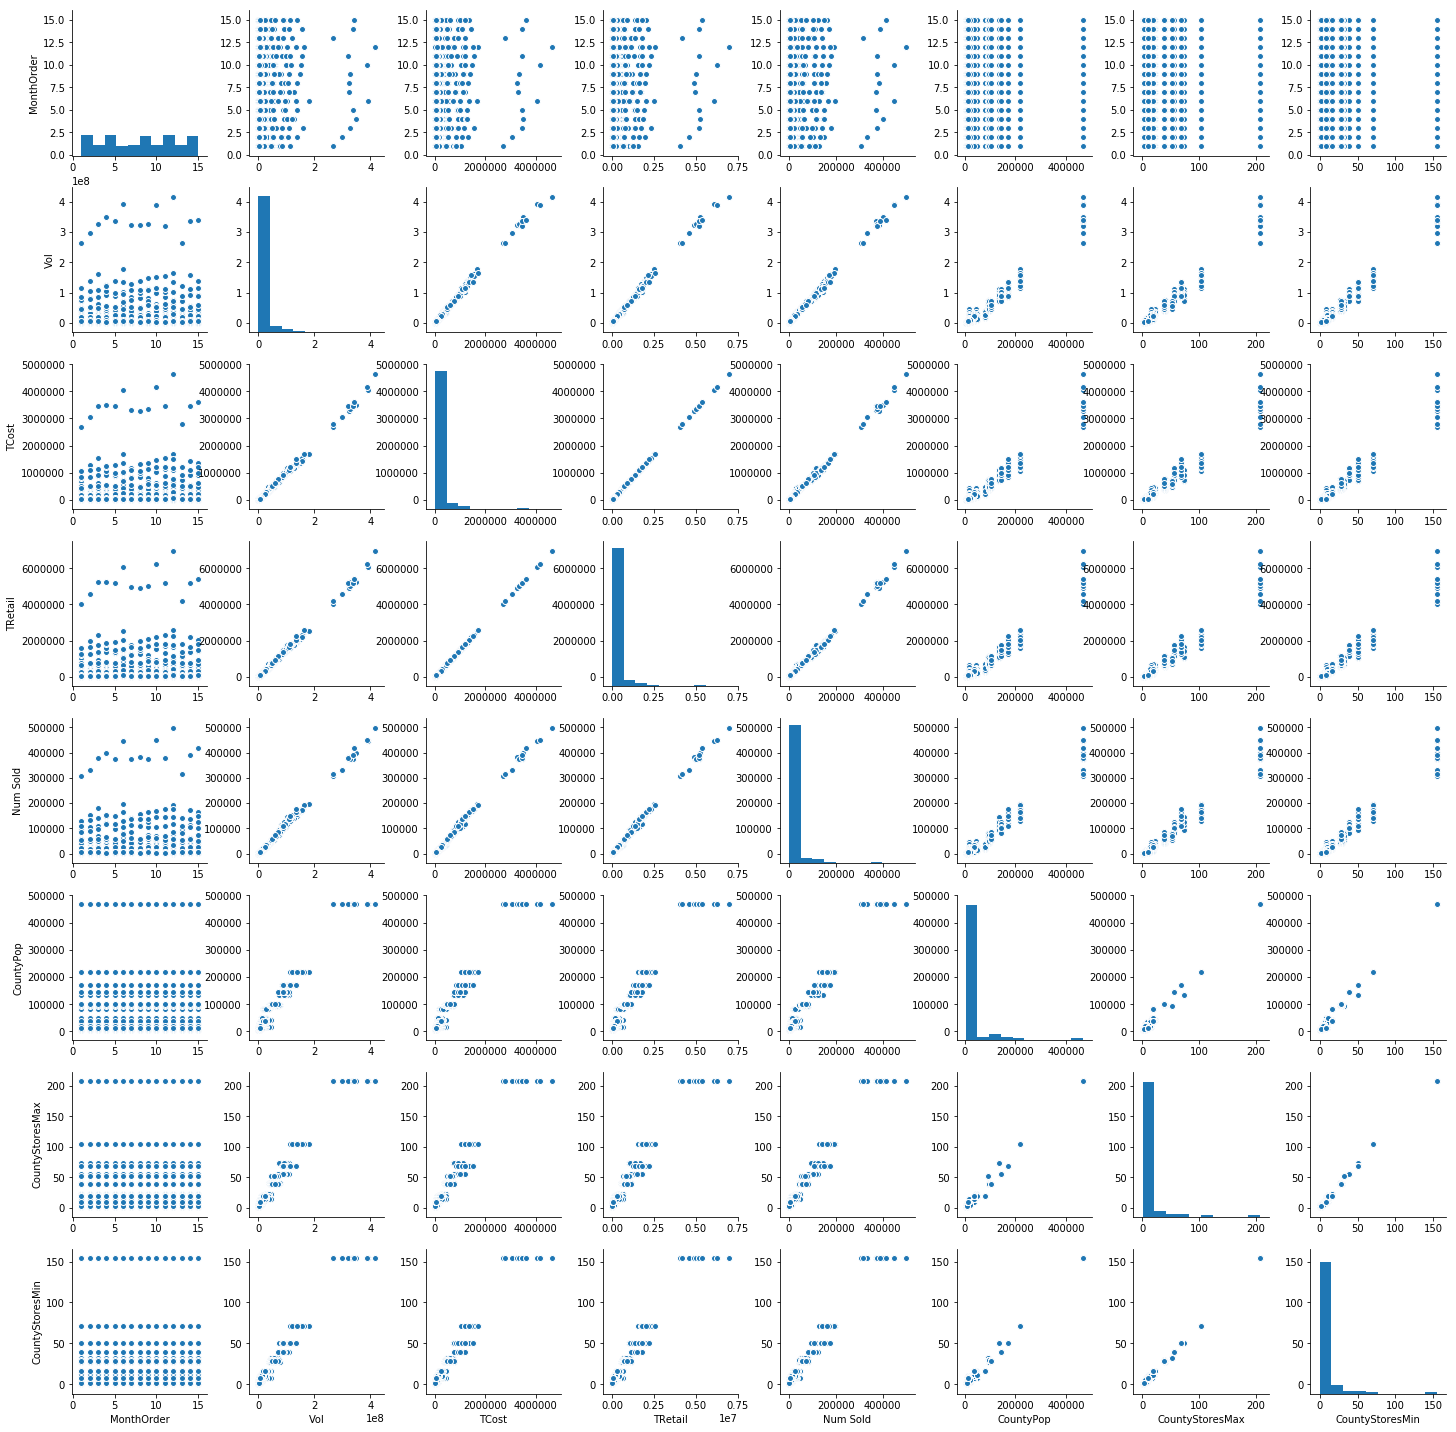

In [215]:
sns.pairplot(countyM.iloc[:,1:])

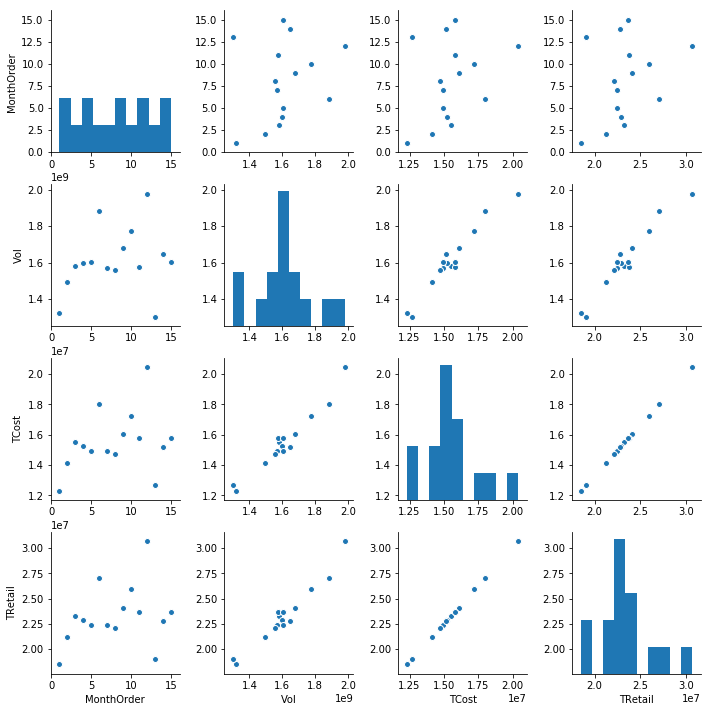

In [216]:
sns.pairplot(stateM.iloc[:,:-1])

# Record your findings

Be sure to write out anything observations from your exploratory analysis.


Most Notably, it appears as if there are very strong 1:1 correlations between variables.

Also, the distributions of populations, sales, etc, all appear to be mostly logarithmic. 

Even store numbers might be logarithmic

# Mine the data

Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations here for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.
 


See above

# Refine the data

Look for any statistical relationships, correlations, or other relevant properties of the dataset.

Correlation heat maps below

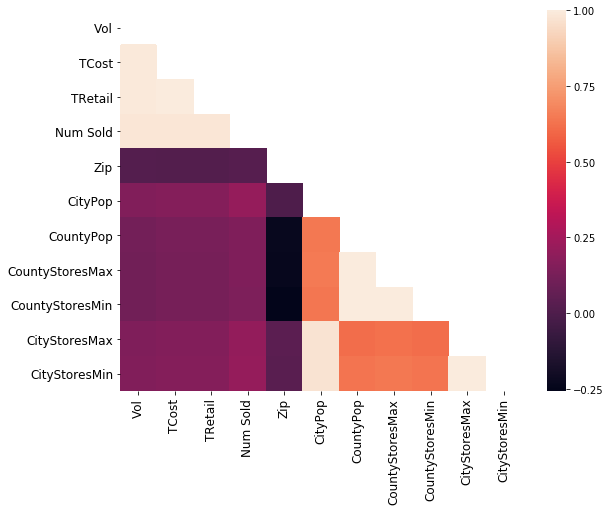

                      Vol     TCost   TRetail  Num Sold       Zip   CityPop  \
Vol              1.000000  0.990636  0.990717  0.983476  0.018629  0.153397   
TCost            0.990636  1.000000  0.999999  0.984304  0.016018  0.165249   
TRetail          0.990717  0.999999  1.000000  0.984318  0.015976  0.165175   
Num Sold         0.983476  0.984304  0.984318  1.000000  0.027778  0.214028   
Zip              0.018629  0.016018  0.015976  0.027778  1.000000  0.002190   
CityPop          0.153397  0.165249  0.165175  0.214028  0.002190  1.000000   
CountyPop        0.112864  0.126536  0.126483  0.149532 -0.228146  0.645453   
CountyStoresMax  0.110002  0.123214  0.123160  0.147092 -0.236306  0.647621   
CountyStoresMin  0.108656  0.121945  0.121893  0.145031 -0.256736  0.639682   
CityStoresMax    0.146238  0.158021  0.157951  0.204910  0.042513  0.973511   
CityStoresMin    0.151248  0.162854  0.162788  0.210445  0.033614  0.974391   

                 CountyPop  CountyStoresMax  County

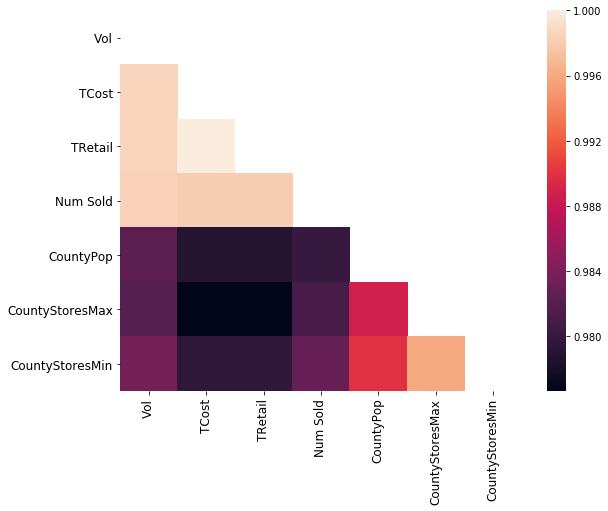

                      Vol     TCost   TRetail  Num Sold  CountyPop  \
Vol              1.000000  0.998614  0.998622  0.998387   0.982216   
TCost            0.998614  1.000000  1.000000  0.998114   0.978912   
TRetail          0.998622  1.000000  1.000000  0.998107   0.978902   
Num Sold         0.998387  0.998114  0.998107  1.000000   0.980088   
CountyPop        0.982216  0.978912  0.978902  0.980088   1.000000   
CountyStoresMax  0.981844  0.976657  0.976648  0.981100   0.988829   
CountyStoresMin  0.983535  0.979532  0.979524  0.982779   0.989964   

                 CountyStoresMax  CountyStoresMin  
Vol                     0.981844         0.983535  
TCost                   0.976657         0.979532  
TRetail                 0.976648         0.979524  
Num Sold                0.981100         0.982779  
CountyPop               0.988829         0.989964  
CountyStoresMax         1.000000         0.995896  
CountyStoresMin         0.995896         1.000000  


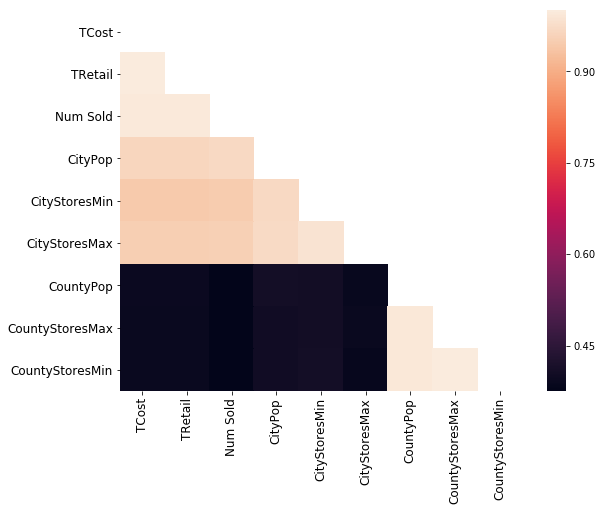

                    TCost   TRetail  Num Sold   CityPop  CityStoresMin  \
TCost            1.000000  1.000000  0.996080  0.965728       0.944127   
TRetail          1.000000  1.000000  0.996072  0.965741       0.944180   
Num Sold         0.996080  0.996072  1.000000  0.969291       0.947525   
CityPop          0.965728  0.965741  0.969291  1.000000       0.969517   
CityStoresMin    0.944127  0.944180  0.947525  0.969517       1.000000   
CityStoresMax    0.951295  0.951332  0.956088  0.971494       0.987423   
CountyPop        0.394877  0.394890  0.377844  0.408343       0.407100   
CountyStoresMax  0.392257  0.392270  0.376312  0.403380       0.406861   
CountyStoresMin  0.392082  0.392096  0.375554  0.402621       0.407930   

                 CityStoresMax  CountyPop  CountyStoresMax  CountyStoresMin  
TCost                 0.951295   0.394877         0.392257         0.392082  
TRetail               0.951332   0.394890         0.392270         0.392096  
Num Sold              0.9

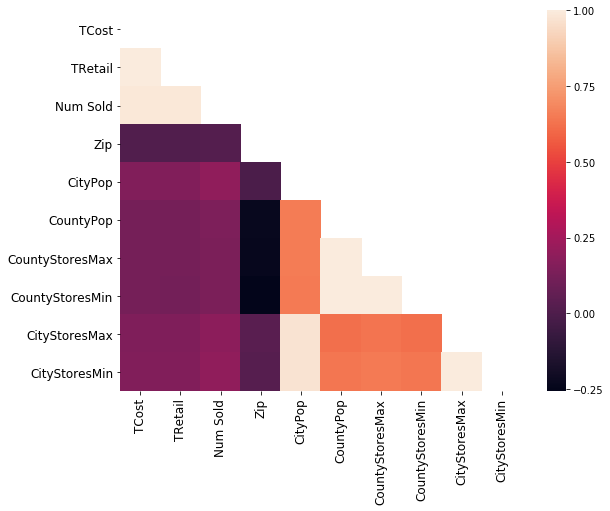

                    TCost   TRetail  Num Sold       Zip   CityPop  CountyPop  \
TCost            1.000000  1.000000  0.986662  0.012689  0.154736   0.121142   
TRetail          1.000000  1.000000  0.986677  0.012646  0.154669   0.121094   
Num Sold         0.986662  0.986677  1.000000  0.023288  0.199662   0.142525   
Zip              0.012689  0.012646  0.023288  1.000000 -0.006030  -0.227213   
CityPop          0.154736  0.154669  0.199662 -0.006030  1.000000   0.652975   
CountyPop        0.121142  0.121094  0.142525 -0.227213  0.652975   1.000000   
CountyStoresMax  0.117458  0.117408  0.139588 -0.235754  0.655528   0.996514   
CountyStoresMin  0.116770  0.116723  0.138266 -0.256184  0.647886   0.997361   
CityStoresMax    0.146515  0.146450  0.189400  0.035769  0.973837   0.620484   
CityStoresMin    0.153345  0.153286  0.197341  0.027234  0.974516   0.639437   

                 CountyStoresMax  CountyStoresMin  CityStoresMax  \
TCost                   0.117458         0.116770  

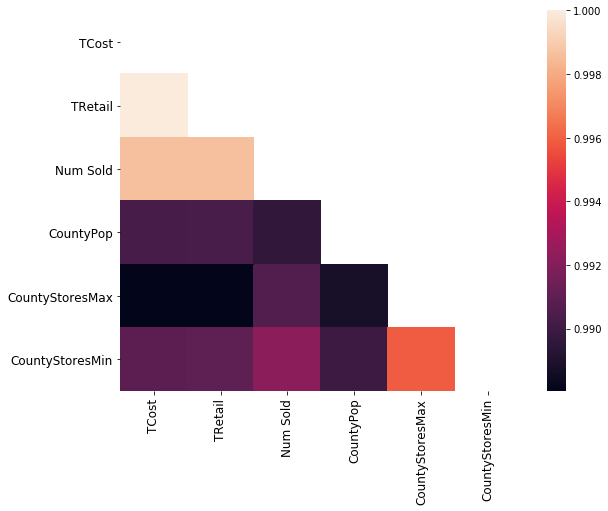

                    TCost   TRetail  Num Sold  CountyPop  CountyStoresMax  \
TCost            1.000000  1.000000  0.998602   0.990332         0.988044   
TRetail          1.000000  1.000000  0.998603   0.990340         0.988054   
Num Sold         0.998602  0.998603  1.000000   0.989595         0.990609   
CountyPop        0.990332  0.990340  0.989595   1.000000         0.988831   
CountyStoresMax  0.988044  0.988054  0.990609   0.988831         1.000000   
CountyStoresMin  0.990939  0.990949  0.992291   0.989959         0.995896   

                 CountyStoresMin  
TCost                   0.990939  
TRetail                 0.990949  
Num Sold                0.992291  
CountyPop               0.989959  
CountyStoresMax         0.995896  
CountyStoresMin         1.000000  


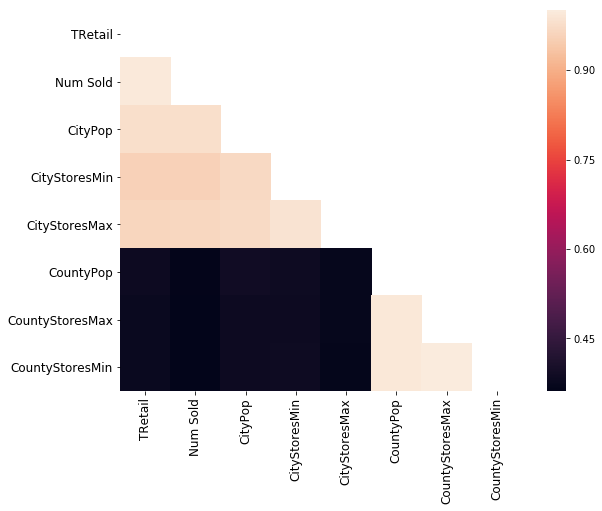

                  TRetail  Num Sold   CityPop  CityStoresMin  CityStoresMax  \
TRetail          1.000000  0.996727  0.978045       0.955641       0.963509   
Num Sold         0.996727  1.000000  0.979817       0.957184       0.966504   
CityPop          0.978045  0.979817  1.000000       0.969033       0.971588   
CityStoresMin    0.955641  0.957184  0.969033       1.000000       0.987076   
CityStoresMax    0.963509  0.966504  0.971588       0.987076       1.000000   
CountyPop        0.382194  0.365018  0.390525       0.386582       0.370245   
CountyStoresMax  0.378156  0.362087  0.384264       0.384430       0.370700   
CountyStoresMin  0.378739  0.362088  0.384288       0.386603       0.368955   

                 CountyPop  CountyStoresMax  CountyStoresMin  
TRetail           0.382194         0.378156         0.378739  
Num Sold          0.365018         0.362087         0.362088  
CityPop           0.390525         0.384264         0.384288  
CityStoresMin     0.386582         0

In [137]:
def heatCorrShow(data):
    fig, ax = plt.subplots(figsize=(9,7))

    mean_corr = data.corr()
    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(mean_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    ax = sns.heatmap(mean_corr, mask=mask, ax=ax)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)

    plt.show()
    print(data.corr())

heatCorrShow(storeM.iloc[:,2:])
heatCorrShow(countyM.iloc[:,2:])
heatCorrShow(cityM.iloc[:,3:])
heatCorrShow(storeY.iloc[:,2:])
heatCorrShow(countyY.iloc[:,2:])
heatCorrShow(cityY.iloc[:,3:])

Again, relationships look very 1:1.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

Reaggrigating store data for each store that sold liquor all 15 months.

Adding data as to the data for city and county that surrounds the store, as these will be used for modeling


In [150]:
storeYF = storeYF.merge(countyY[['County','Vol','TRetail', 'Num Sold']], on = 'County', suffixes= ('','_County'))
storeYF = storeYF.merge(cityY[['City','Vol','TRetail', 'Num Sold', 'County']], on = ['City','County'], suffixes = ('_Store', '_City'))


Final factor manufacturing. 

In essence building a model that will look at the dollar market share of each store in its county.

As the retail sales appeared logrithmic, taking the log of this target variable.

Will regress upon the stores/population of both county and city; the 'liquor convenience' of each area.  

Then regressing upon interaction the volume * number of bottles sold in the city and county, per population. Again taking log in deference to variables distributions.  



In [180]:
storeYF['StPerCountyRetail'] = np.log10(storeYF['TRetail_Store'] / storeYF['TRetail_County'])
storeYF['CityStoresPerCityPop'] = ((storeYF['CityStoresMax'] + storeYF['CityStoresMin']) / 2) / storeYF['CityPop']
storeYF['CountyStoresPerCountyPop'] = ((storeYF['CountyStoresMax'] + storeYF['CountyStoresMin']) / 2) / storeYF['CountyPop']
storeYF['CityLuxuryInteraction'] = np.log10((storeYF['Vol_City'] * storeYF['Num Sold_City'])/storeYF['CityPop'])
storeYF['CountyLuxuryInteraction'] = np.log10((storeYF['Vol_County'] * storeYF['Num Sold_County']) / storeYF['CountyPop'])

In [208]:
import statsmodels.api as sm

y = storeYF['StPerCountyRetail']
x = sm.add_constant(storeYF[['CityStoresPerCityPop','CountyStoresPerCountyPop',
                                'CityLuxuryInteraction','CountyLuxuryInteraction']])

ols = sm.OLS(y, x).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      StPerCountyRetail   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     542.7
Date:                Thu, 08 Feb 2018   Prob (F-statistic):          2.99e-245
Time:                        20:10:37   Log-Likelihood:                -621.99
No. Observations:                 971   AIC:                             1254.
Df Residuals:                     966   BIC:                             1278.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        4.9484      0.185     26.714      0.000       4.585       5.312
CityStoresPerCityPop       -11.7985      9.511     -1.240      0.215     -30.464       6.867
CountyStoresPerCountyPop   164.4990    142.651      1.153      0.249    -115.442     444.440
CityLuxuryInteraction        0.2474      0.021     12.045      0.000       0.207       0.288
CountyLuxuryInteraction     -0.9301      0.023    -41.022      0.000      -0.975      -0.886
==============================================================================
Omnibus:                       22.989   Durbin-Watson:                   1.257
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.690
Skew:                           0.365   Prob(JB):                     7.17e-06
Kurtosis:                       2.771   Cond. No.                     1.29e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Given that we are assuming that there is differential in stores performance, a ~70% r^2 seems acceptable

In [204]:
results = pd.concat([ols.predict(x), y], axis = 1)
results.columns = ['predicted', 'actual']
results['diff'] = results['actual']-results['predicted']
top = results.sort_values('diff', ascending = False).head(10).index

Looking at the stores with top market shares per county/city. 

It maybe isn't surprising that stores in large cities top the list. While this is looking at county market share, a successful city liquor store will likely have high county market share becuase the city market share overwhelms demand in the rest of the county.

In [207]:
for i in top:
    print(storeYF.loc[i,['City','County','StNum']])

City      DES MOINES
County          Polk
StNum           2633
Name: 95, dtype: object
City      DES MOINES
County          Polk
StNum           4829
Name: 139, dtype: object
City      IOWA CITY
County      Johnson
StNum          2512
Name: 268, dtype: object
City      BETTENDORF
County         Scott
StNum           3952
Name: 627, dtype: object
City      CEDAR RAPIDS
County            Linn
StNum             3385
Name: 475, dtype: object
City        MILFORD
County    Dickinson
StNum          3390
Name: 264, dtype: object
City      WINDSOR HEIGHTS
County               Polk
StNum                3420
Name: 208, dtype: object
City      CORALVILLE
County       Johnson
StNum           2670
Name: 288, dtype: object
City      URBANDALE
County         Polk
StNum          2663
Name: 212, dtype: object
City      CARROLL
County    Carroll
StNum        2593
Name: 694, dtype: object


# Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

Text(0.5,1,'Plot of predicted v. actual')

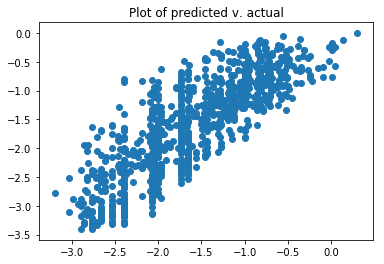

In [219]:
plt.scatter(results['predicted'], results['actual'])
plt.title('Plot of predicted v. actual');

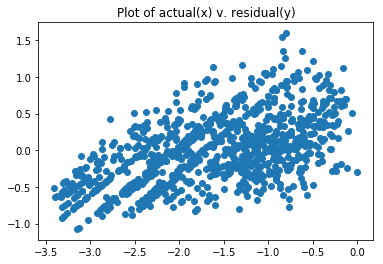

In [221]:
plt.scatter(results['actual'], results['diff'])
plt.title('Plot of actual(x) v. residual(y)');

It appears as if maybe there is some structure to the residuals of some positive slope.

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.

Above an attempt was made at descriptive statistics; where are the highest performing liquor stores.  

In thinking about where might be the best place for a new store, there are different considerations.  

The above model suggests that success of a store is determined by the convenience of other liquor stores (stores/population), and how "thirsty" a county are. This is modeled by both number of bottles sold and volume sold. Both might be indicative of how much a location wants to drink. (many small bottles, or fewer large ones).

As such, what this model suggests is that locations with relatively low volume and bottles per person will be good candidates for other stores. 

Furthermore, in deference to the "convenience" factor, a high volume per bottle might suggest that increased convenience would encourage people to do less "stocking up" and more "running around the corner" to the store.

In [223]:
cityY.head(3)

,City,Vol,TCost,TRetail,Num Sold,CityPop,CityStoresMin,CityStoresMax,CountyPop,CountyStoresMax,CountyStoresMin,County
0,ACKLEY,7121525,54276.42,81583.88,6714,1513,2,2,17276,13,9,Hardin
1,ADAIR,3276300,32020.90,48094.26,4415,709,0,2,7211,8,4,Adair
2,ADEL,31819450,274281.30,412478.63,33037,3995,2,3,80777,20,16,Dallas


In [231]:
cityY[cityY['VolPerPerson']>100000
     ]

,City,Vol,TCost,TRetail,Num Sold,CityPop,CityStoresMin,CityStoresMax,CountyPop,CountyStoresMax,CountyStoresMin,County,VolPerPerson,BottPerPerson,VolPerBottle
354,WEST BEND,13644625,101126.40,152165.72,9787,23,1,1,15155,7,7,Kossuth,593244.565217,425.521739,1394.158067
369,ZWINGLE,3047125,27941.87,41945.47,4307,25,0,1,19454,8,5,Jackson,121885.000000,172.280000,707.482006


,City,Vol,TCost,TRetail,Num Sold,CityPop,CityStoresMin,CityStoresMax,CountyPop,CountyStoresMax,CountyStoresMin,County,VolPerPerson,BottPerPerson,VolPerBottle
84,DELHI,415675,4536.57,6813.30,721,470,0,1,17406,5,3,Delaware,884.414894,1.534043,576.525659
155,HAZLETON,3659100,33256.95,49940.56,7294,819,1,1,21084,9,9,Buchanan,4467.765568,8.905983,501.658898
204,MALVERN,2899500,25225.80,37898.50,4112,1073,0,1,14815,6,5,Mills,2702.236719,3.832246,705.131323
218,MECHANICSVILLE,2640600,23847.82,35819.70,4238,1115,1,1,18362,9,7,Cedar,2368.251121,3.800897,623.076923
222,MERRILL,946025,7966.88,11965.27,1406,737,0,1,24913,8,7,Plymouth,1283.616011,1.907734,672.848506
314,STANWOOD,2569800,23604.62,35431.98,3656,663,0,1,18362,9,7,Cedar,3876.018100,5.514329,702.899344


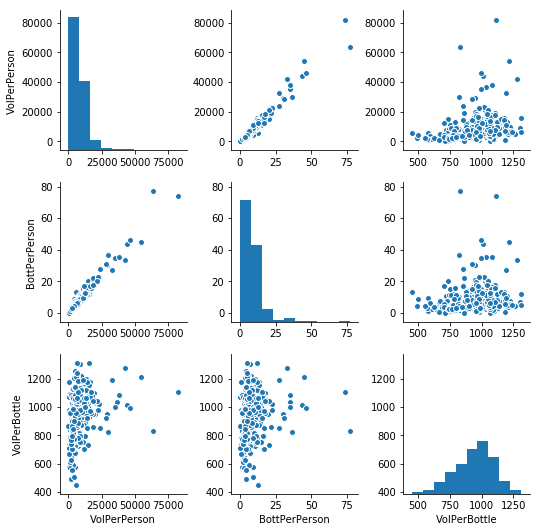

In [241]:
#cityY = cityY.merge(countyY[['County','Vol','TRetail', 'Num Sold']], on = 'County', suffixes= ('_City','_County'))

cityY['VolPerPerson']= cityY['Vol']/cityY['CityPop']
cityY['BottPerPerson'] = cityY['Num Sold'] / cityY['CityPop']
cityY['VolPerBottle'] = cityY['Vol'] / cityY['Num Sold']
citys = cityY.drop([354,369])
sns.pairplot(citys.iloc[:,-3:]);
cityY[(cityY['BottPerPerson']<10)& (cityY['VolPerBottle']<750) & (cityY['CountyStoresMax']<10) & (cityY['CountyPop']>10000)]

Text(0.5,1,'Log10 Total Retail')

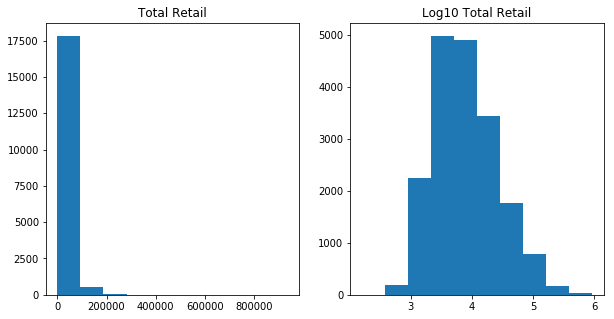

In [254]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.hist(storeM['TRetail']);
plt.title('Total Retail')

plt.subplot(122)
plt.hist(np.log10(storeM['TRetail']))
plt.title('Log10 Total Retail')

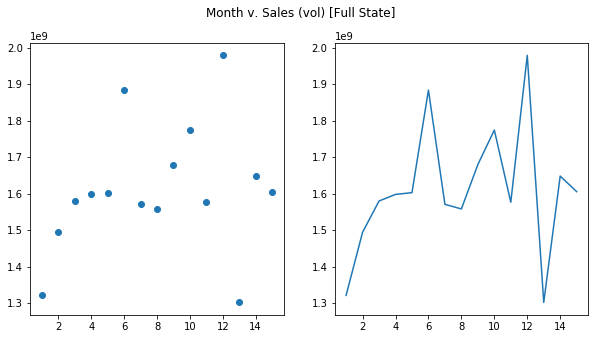

In [252]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.scatter(stateM['MonthOrder'], stateM['Vol'])
plt.suptitle('Month v. Sales (vol) [Full State]')
plt.subplot(122)
plt.plot(stateM['MonthOrder'], stateM['Vol']);

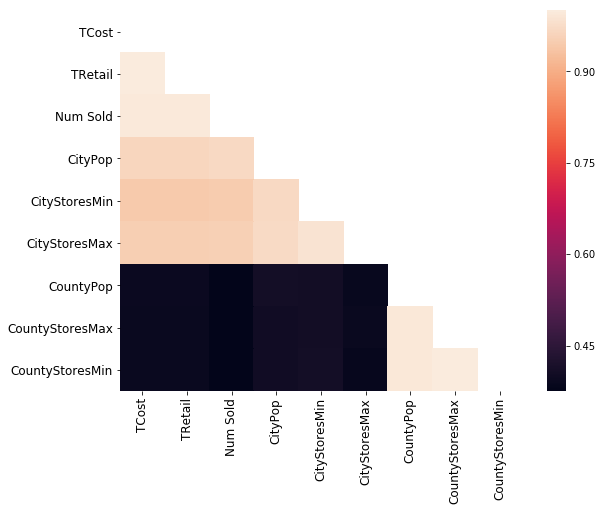

                    TCost   TRetail  Num Sold   CityPop  CityStoresMin  \
TCost            1.000000  1.000000  0.996080  0.965728       0.944127   
TRetail          1.000000  1.000000  0.996072  0.965741       0.944180   
Num Sold         0.996080  0.996072  1.000000  0.969291       0.947525   
CityPop          0.965728  0.965741  0.969291  1.000000       0.969517   
CityStoresMin    0.944127  0.944180  0.947525  0.969517       1.000000   
CityStoresMax    0.951295  0.951332  0.956088  0.971494       0.987423   
CountyPop        0.394877  0.394890  0.377844  0.408343       0.407100   
CountyStoresMax  0.392257  0.392270  0.376312  0.403380       0.406861   
CountyStoresMin  0.392082  0.392096  0.375554  0.402621       0.407930   

                 CityStoresMax  CountyPop  CountyStoresMax  CountyStoresMin  
TCost                 0.951295   0.394877         0.392257         0.392082  
TRetail               0.951332   0.394890         0.392270         0.392096  
Num Sold              0.9

In [253]:
heatCorrShow(cityM.iloc[:,3:])

### Deprecated

In [410]:
def createLogVars(data, cols):
    df = data.copy()
    for c in cols:
            name = 'log'+ c 
            df[name] = np.log10(df[c])
    return df

In [168]:
def createDivVars(data, cols1, cols2):
    df = data.copy()
    for c1 in cols1:
        for c2 in cols2:
            name = c1 + 'Per' + c2
            df[name] = df[c1]/df[c2]
    return df

LC = createDivVars(LC, ['TRetail'],['Num Sold','Vol','CountyPop','CityPop','CityStores','CountyStores'])
cityC = createDivVars(cityC,['TRetail'],['Num Sold','Vol','CountyPop','CityPop','CityStores','CountyStores'])
countyC = createDivVars(countyC, ['TRetail'], ['Num Sold','Vol','CountyPop','CountyStores'])

In [220]:
# Building Reference Tables

def buildTable(keyCol, valCols, data):
    to = time.time()
    dic = {}
    
    for row in data.iterrows():
        key = row[1][keyCol].iloc[0]
        value = tuple(row[1][valCols])
        # print(key)
        # print(value)
        if key in dic:
            if value in dic[key]:
                pass
            else:
                dic[key].append(value)
        else:
            temp = list()
            temp.append(value)
            dic[key] = temp
            
    t1 = time.time()
    print(t1-to)
    return dic

storeTable= buildTable(['StNum'], ['City','Zip','County'], liquor)
errors = []
for k in storeTable:
    if len(storeTable[k])!=1:
        errors.append(k)
        
for k in errors:
        storeTable[k]= [storeTable[k][1]]
        
for k in storeTable:
    storeTable[k] = list(storeTable[k][0])

df = pd.DataFrame()
df=df.from_dict(storeTable, orient = 'index' )
df.info()
df.columns = ['City', 'Zip','County']
df.to_csv('C:/Users/William/Documents/GA/Data/storeTable.csv')

2975.470918416977


TypeError: 'int' object is not iterable

In [220]:
# Building Reference Tables

def buildTable(keyCol, valCols, data):
    to = time.time()
    dic = {}
    
    for row in data.iterrows():
        key = row[1][keyCol].iloc[0]
        value = tuple(row[1][valCols])
        # print(key)
        # print(value)
        if key in dic:
            if value in dic[key]:
                pass
            else:
                dic[key].append(value)
        else:
            temp = list()
            temp.append(value)
            dic[key] = temp
            
    t1 = time.time()
    print(t1-to)
    return dic

storeTable= buildTable(['StNum'], ['City','Zip','County'], liquor)
errors = []
for k in storeTable:
    if len(storeTable[k])!=1:
        errors.append(k)
        
for k in errors:
        storeTable[k]= [storeTable[k][1]]
        
for k in storeTable:
    storeTable[k] = list(storeTable[k][0])

df = pd.DataFrame()
df=df.from_dict(storeTable, orient = 'index' )
df.info()
df.columns = ['City', 'Zip','County']
df.to_csv('C:/Users/William/Documents/GA/Data/storeTable.csv')

2975.470918416977


TypeError: 'int' object is not iterable

In [412]:
stList_target = 'C:/Users/William/Documents/GA/Data/storeTable.csv'
liquor_agg_target = 'C:/Users/William/Documents/GA/Data/LiquorAgg.csv'
city_agg_target = 'C:/Users/William/Documents/GA/Data/cityAgg.csv'
county_agg_target = 'C:/Users/William/Documents/GA/Data/countyAgg.csv'
state_agg_target = 'C:/Users/William/Documents/GA/Data/stateAgg.csv'

cityC = pd.read_csv(city_agg_target, index_col = 0)
countyC = pd.read_csv(county_agg_target, index_col = 0)
stList = pd.read_csv(stList_target, index_col = 0)
LC = pd.read_csv(liquor_agg_target, index_col = 0)
stateC = pd.read_csv(state_agg_target, index_col = 0)

In [220]:
# Building Reference Tables

def buildTable(keyCol, valCols, data):
    to = time.time()
    dic = {}
    
    for row in data.iterrows():
        key = row[1][keyCol].iloc[0]
        value = tuple(row[1][valCols])
        # print(key)
        # print(value)
        if key in dic:
            if value in dic[key]:
                pass
            else:
                dic[key].append(value)
        else:
            temp = list()
            temp.append(value)
            dic[key] = temp
            
    t1 = time.time()
    print(t1-to)
    return dic

storeTable= buildTable(['StNum'], ['City','Zip','County'], liquor)
errors = []
for k in storeTable:
    if len(storeTable[k])!=1:
        errors.append(k)
        
for k in errors:
        storeTable[k]= [storeTable[k][1]]
        
for k in storeTable:
    storeTable[k] = list(storeTable[k][0])

df = pd.DataFrame()
df=df.from_dict(storeTable, orient = 'index' )
df.info()
df.columns = ['City', 'Zip','County']
df.to_csv('C:/Users/William/Documents/GA/Data/storeTable.csv')

2975.470918416977


TypeError: 'int' object is not iterable

In [305]:
stList_target = 'C:/Users/William/Documents/GA/Data/storeTable.csv'
cityList_target = 'C:/Users/William/Documents/GA/Data/cityTable.csv'
countyList_target = 'C:/Users/William/Documents/GA/Data/countyTable.csv'

state_agg_target = 'C:/Users/William/Documents/GA/Data/stateAgg.csv'
liquor_agg_target = 'C:/Users/William/Documents/GA/Data/LiquorAgg.csv'
city_agg_target = 'C:/Users/William/Documents/GA/Data/cityAgg.csv'
county_agg_target = 'C:/Users/William/Documents/GA/Data/countyAgg.csv'

import pandas as pd
# Create Totals per line that describe total volume, cost and retail per store/product/month

LA = liquor.drop(['Invoice','Zip', 'Date', 'VenNum', 'Item', 'Pack', 'Year', 'ItNum'], axis = 'columns')
LA['Vol'] = LA['BottVol'] * LA['Num Sold']
LA['TCost'] = LA['Num Sold'] * LA['Cost']
LA['TRetail'] = LA['Num Sold'] * LA['Retail']
LA = LA.drop(['BottVol','Cost','Retail'], axis = 'columns')

####
# Build State / Month Aggregation
####

stateC = pd.concat([LA.groupby('MonthOrder')['Vol'].sum(),
                    LA.groupby('MonthOrder')['TCost'].sum(),
                    LA.groupby('MonthOrder')['TRetail'].sum(),
                    LA.groupby('MonthOrder')['Num Sold'].sum()],
                   axis = 1)
stateC['MonthOrder'] = stateC.index
stateC.index = range(0,len(stateC))
stateC = stateC[['MonthOrder','Vol','TCost','TRetail','Num Sold']]
stateC['statePop' ] = pop['Population'].sum()


####
# Build a per store / Month aggregation
####
LC = pd.concat([LA.groupby(['StNum','MonthOrder'])['Vol'].sum(), 
                LA.groupby(['StNum','MonthOrder'])['TCost'].sum(), 
                LA.groupby(['StNum','MonthOrder'])['TRetail'].sum(), 
                LA.groupby(['StNum','MonthOrder'])['Num Sold'].sum()],
               axis = 1)

# Getting rid of multi-index, and re-index
LC['StNum'] = LC.index.map(lambda x: x[0])
LC['MonthOrd'] = LC.index.map(lambda x: x[1])
LC.index = range(0,len(LC))

# Arrange Columns
cols = LC.columns.tolist()
cols = cols[-2:]+cols[:-2]
LC = LC[cols]


# Merge with the "Store List"
stList = pd.read_csv(stList_target)
LC = LC.merge(stList[['CountyPop','CityPop','StNum', 'CityStores','CountyStores']], left_on = 'StNum', right_on = 'StNum')



#LC = LC.merge(stList[['City','County','StNum']], left_on = 'StNum', right_on = 'StNum')





####
# Build per county / month aggregation
####

countyC = pd.concat([LA.groupby(['County','MonthOrder'])['Vol'].sum(), 
                LA.groupby(['County','MonthOrder'])['TCost'].sum(), 
                LA.groupby(['County','MonthOrder'])['TRetail'].sum(), 
                LA.groupby(['County','MonthOrder'])['Num Sold'].sum()],
               axis = 1)

# Rid of multi-index
countyC['County'] = countyC.index.map(lambda x: x[0])
countyC['MonthOrd'] = countyC.index.map(lambda x: x[1])
countyC.index = range(0,len(countyC))

#Arrange Columns
cols = countyC.columns.tolist()
cols = cols[-2:]+cols[:-2]
countyC = countyC[cols]

# Merge with "County" list
countyList = pd.read_csv(countyList_target, index_col = 0)
countyC = countyC.merge(countyList[['CountyPop','County','CountyStores']], on = 'County')

####
# Build city/month aggregate
####

cityC = pd.concat([LA.groupby(['City','County','MonthOrder'])['Vol'].sum(), 
                LA.groupby(['City','County','MonthOrder'])['TCost'].sum(), 
                LA.groupby(['City','County','MonthOrder'])['TRetail'].sum(), 
                LA.groupby(['City','County','MonthOrder'])['Num Sold'].sum()],
               axis = 1)

# Rid of Multi-index
cityC['City'] = cityC.index.map(lambda x: x[0])
cityC['County'] = cityC.index.map(lambda x: x[1])
cityC['MonthOrd'] = cityC.index.map(lambda x: x[2])
cityC.index = range(0,len(cityC))

# Arrange Columns
cols = cityC.columns.tolist()
cols = cols[-3:] + cols[:-3]
cityC = cityC[cols]

# Merge with City List, then County List
cityList = pd.read_csv(cityList_target, index_col = 0)
cityC = cityC.merge(cityList[['CityPop','City', 'CityStores']], on = 'City')
cityC = cityC.merge(countyList, on = 'County')

#Write new tables
cityC.to_csv(city_agg_target)
stateC.to_csv(state_agg_target)
LC.to_csv( liquor_agg_target )
countyC.to_csv(county_agg_target)

#Delete All Objects
del(countyList)
del(cityList)
del(stateC)
del(cityC)
del(countyC)
del(stList)
del(LC)

In [172]:
vol = findDuplicates('ItNum','BottVol', liquor)
cost = findDuplicates('ItNum','Cost', liquor)
retail = findDuplicates('ItNum','Retail', liquor)

liquor['Profit'] = liquor['Retail']-liquor['Cost']

profit = findDuplicates('ItNum', 'Profit', liquor)

-171.93240213394165
-129.45540690422058
-136.14522671699524
-136.5183093547821


In [129]:
print(vol)
print(len(cost))
print(len(retail))
len([k for k in cost if k in retail])
[k for k in cost if k not in retail]
[k for k in retail if k not in cost]
[k for k in profit if k  not in retail]

{238: [1500, 750], 464: [2550, 850], 12865: [250, 600]}
663
668


[86644.0, 86641.0]

In [209]:
liquor[liquor['ItNum'] ==86644].head()

,Invoice,Date,StNum,City,Zip,County,VenNum,ItNum,Item,Pack,BottVol,Cost,Retail,Num Sold,Markup,Month,Year,MonthOrder
15657,S27068200305,2015-07-30,2515,MASON CITY,50401,Cerro Gordo,35,86644,Bonnie Rose Orange Peel Mini,10,600,8.4,8.4,2,1.0,7,2015,7
22540,S26197800033,2015-06-16,2327,CORNING,50841,Adams,35,86644,Bonnie Rose Orange Peel Mini,10,600,8.4,8.4,1,1.0,6,2015,6
25348,S25697200041,2015-05-18,2613,COUNCIL BLUFFS,51501,Pottawattamie,35,86644,Bonnie Rose Orange Peel Mini,10,600,8.4,8.4,1,1.0,5,2015,5
83087,S26202400047,2015-06-15,2521,WEST DES MOINES,50265,Polk,35,86644,Bonnie Rose Orange Peel Mini,10,600,8.4,8.4,10,1.0,6,2015,6
87509,S28007200152,2015-09-21,2506,BURLINGTON,52601,Des Moines,35,86644,Bonnie Rose Orange Peel Mini,10,600,5.6,8.4,1,1.5,9,2015,9


In [387]:
def createParams(data, groups, target):
    df=pd.concat([data.groupby(groups)[target].mean(),data.groupby(groups)[target].var()], axis = 1)

    df.columns = ['mu', 'var']
    df['b'] = df['mu']/df['var']
    df['a'] = (df['mu']**2)/ df['var']
    
    return df

cityP = createParams(cityC, ['City','County'], 'Vol')
countyP = createParams(countyC, ['County'], 'Vol')
storeP = createParams(LC, ['StNum'], 'Vol')

cityP.head()


,,mu,var,b,a
City,County,,,,
ACKLEY,Hardin,4.747683e+05,2.410614e+10,0.000020,9.350522
ADAIR,Adair,2.340214e+05,1.081725e+10,0.000022,5.062844
ADEL,Dallas,2.121297e+06,4.006572e+11,0.000005,11.231296
AFTON,Union,2.195308e+05,7.466019e+09,0.000029,6.455081
AKRON,Plymouth,2.716417e+05,9.627341e+09,0.000028,7.664546


Text(0.5,1,'Norm')

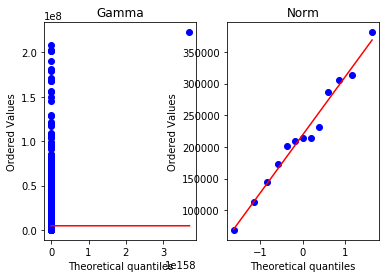

In [398]:
fig = plt.figure()
ax = fig.add_subplot(121)
x = stats.loggamma.rvs(c=2.5, size=500)
res = stats.probplot(cityC['Vol'], dist=stats.lognorm, sparams =(100), plot=ax)
ax.set_title("Gamma")

ax = fig.add_subplot(122)
x = stats.loggamma.rvs(c=2.5, size=500)
res = stats.probplot(cityC[cityC['City']=='AFTON']['Vol'], plot=ax)
ax.set_title("Norm")